In [1]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy

from src.model import JEPA, Encoder, Predictor
from src.dataprep import sample_mask
from src.helper import update_ema

device = "mps" if torch.mps.is_available() else "cpu"
torch.manual_seed(0)

# prevent file paths from being printed
import warnings
warnings.filterwarnings("ignore")

## Hyperparameters

In [2]:
# image
img_size = 64
patch_size = 8
grid_size = img_size // patch_size
num_patches = grid_size ** 2

# encoder
encoder_dim = 256
encoder_depth = 8
encoder_heads = 4

# predictor
predictor_dim = 128
predictor_depth = 4
predictor_heads = 4

# training
batch_size = 64
lr = 0.0001
ema_decay = 0.96
num_steps = 2000

## Data processing

In [3]:
train_transform =  transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

train_dataset = datasets.ImageFolder(
    root="data/tiny-imagenet-200/train",
    transform=train_transform,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

## Model initialization

In [4]:
context_encoder = Encoder(
    in_channels=3,
    img_size=img_size,
    patch_size=patch_size,
    embed_dim=encoder_dim,
    depth=encoder_depth,
    heads=encoder_heads,
    mlp_ratio=4.0,
).to(device)

 # copy context encoder and prevent loss based weight updates
target_encoder = copy.deepcopy(context_encoder).to(device)
target_encoder.eval()
for p in target_encoder.parameters():
    p.requires_grad = False

predictor = Predictor(
    encoder_dim=encoder_dim,
    predictor_dim=predictor_dim,
    num_patches=num_patches,
    heads=predictor_heads,
    mlp_ratio=4.0,
    depth=4,
).to(device)

model = JEPA(context_encoder, predictor).to(device)

## Training

In [5]:
optimizer = AdamW(model.parameters(), lr=lr)

def train_step(x):
    # generate masks for the entire batch
    B = x.size(0)
    visible_idx = []
    masked_idx = []
    for _ in range(B):
        v, m = sample_mask(grid_size, block_size=2)
        visible_idx.append(v)
        masked_idx.append(m)
    visible_idx = torch.stack(visible_idx).to(device)
    masked_idx = torch.stack(masked_idx).to(device)

    # forward both the context and the target
    pred = model(x, visible_idx, masked_idx)
    with torch.no_grad():
        target = target_encoder(x, masked_idx)

    # calculate loss and gradients
    loss = F.mse_loss(pred, target)
    optimizer.zero_grad()
    loss.backward()

    # perform weight update for context and target
    optimizer.step()
    update_ema(context_encoder, target_encoder, ema_decay)

    return loss.item()

In [6]:
loss_history = []
model.train()
step = 0

for epoch in range(1000):
    for x, _ in train_loader:
        x = x.to(device)

        loss = train_step(x)
        loss_history.append(loss)

        if step % 100 == 0:
            print(f"step {step} | loss {loss}")

        step += 1

        # train for given number of steps
        if step >= num_steps:
            break
    if step >= num_steps:
        break

step 0 | loss 1.3354666233062744
step 100 | loss 0.096375472843647
step 200 | loss 0.027035854756832123
step 300 | loss 0.06875521689653397
step 400 | loss 0.2957727611064911
step 500 | loss 0.4365578293800354
step 600 | loss 0.280085951089859
step 700 | loss 0.22348418831825256
step 800 | loss 0.12207614630460739
step 900 | loss 0.07252362370491028
step 1000 | loss 0.0762944221496582
step 1100 | loss 0.05828682333230972
step 1200 | loss 0.05122488737106323
step 1300 | loss 0.04190339893102646
step 1400 | loss 0.03869158774614334
step 1500 | loss 0.03469548374414444
step 1600 | loss 0.03104471229016781
step 1700 | loss 0.027992287650704384
step 1800 | loss 0.024608606472611427
step 1900 | loss 0.02445581555366516


## Plots

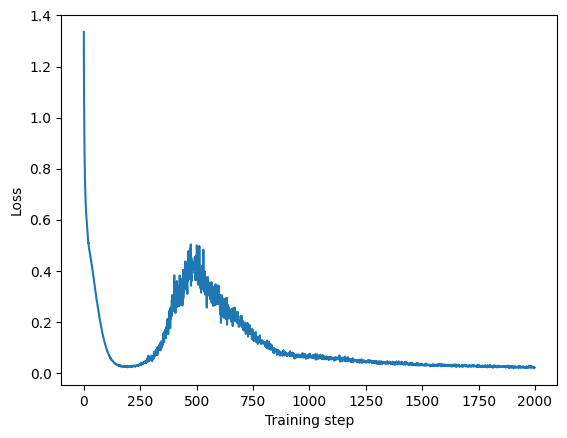

In [7]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.show()

Loss drops quickly as the predictor learns the ema target, then rises as the target lags behind, and finally stabilizes which is expected JEPA behavior.